In [1]:
import tensorflow as tf
import numpy as np

In [ ]:
features = ["AOT", "B01", "B02", "B03", "B04", "B05", "B06", "B08", "B8A", "B09", "B11","B12", "WVP"]

In [2]:
graph_def = tf.compat.v1.GraphDef()

In [3]:
predict_file = tf.io.gfile.GFile("l2a_unet.pb", 'rb')
graph_def.ParseFromString(predict_file.read())
predict_graph = tf.import_graph_def(graph_def, name='predict')
predict_sess = tf.compat.v1.Session(graph=predict_graph)
predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/Model/conv2d_23/truediv:0") 
predict_input = predict_sess.graph.get_tensor_by_name(f"predict/Model/input:0")
#predict_inp = predict_sess.graph.get_tensor_by_name("predict/Placeholder:0")
#predict_length = predict_sess.graph.get_tensor_by_name("predict/PlaceholderWithDefault:0")

In [4]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['predict/Model/input',
 'predict/Model/conv2d/kernel',
 'predict/Model/conv2d/bias',
 'predict/Model/conv2d/Conv2D/ReadVariableOp',
 'predict/Model/conv2d/Conv2D',
 'predict/Model/conv2d/BiasAdd/ReadVariableOp',
 'predict/Model/conv2d/BiasAdd',
 'predict/Model/conv2d/Relu',
 'predict/Model/conv2d_1/kernel',
 'predict/Model/conv2d_1/bias',
 'predict/Model/conv2d_1/Conv2D/ReadVariableOp',
 'predict/Model/conv2d_1/Conv2D',
 'predict/Model/conv2d_1/BiasAdd/ReadVariableOp',
 'predict/Model/conv2d_1/BiasAdd',
 'predict/Model/conv2d_1/Relu',
 'predict/Model/max_pooling2d/MaxPool',
 'predict/Model/conv2d_2/kernel',
 'predict/Model/conv2d_2/bias',
 'predict/Model/conv2d_2/Conv2D/ReadVariableOp',
 'predict/Model/conv2d_2/Conv2D',
 'predict/Model/conv2d_2/BiasAdd/ReadVariableOp',
 'predict/Model/conv2d_2/BiasAdd',
 'predict/Model/conv2d_2/Relu',
 'predict/Model/conv2d_3/kernel',
 'predict/Model/conv2d_3/bias',
 'predict/Model/conv2d_3/Conv2D/ReadVariableOp',
 'predict/Model/conv2d_3/Conv2D',
 'p

In [4]:
def _wvp(arr):
    return arr[..., 6] / arr[..., 7]

In [5]:
stds =  [0.000845261150971055, 0.041299913078546524, 0.039003968238830566, 0.03623047098517418,
         0.03549625352025032, 0.036688629537820816, 0.03459501639008522, 0.03538798168301582,
         0.03376650810241699, 0.060521017760038376, 0.02391253225505352, 0.021194500848650932,
         0.0115975895896554]
means = [0.0016591775929555297, 0.029182588681578636, 0.02786719985306263, 0.028459852561354637,
         0.02683664672076702, 0.032926056534051895, 0.044384393841028214, 0.05008489266037941, 
         0.05016825720667839, 0.06914236396551132, 0.03178902342915535, 0.023803194984793663,
         0.020374732092022896]
min_v = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
max_v = np.array([0.003906309604644775, 0.2833447754383087, 0.27905699610710144, 0.2668497860431671, 
         0.2558480203151703, 0.250980406999588, 0.24597543478012085, 0.24182498455047607, 
         0.24206912517547607, 0.2535133957862854, 0.2232242375612259, 0.23524834215641022,
         0.07557793706655502])

def minmax(arr):
    return (arr - min_v) / (max_v - min_v)

In [6]:
import hickle as hkl
arr10 = hkl.load("../../project-monitoring/tiles/2435/958/raw/s2_10/2435X958Y.hkl")
arr20 = hkl.load("../../project-monitoring/tiles/2435/958/raw/s2_20/2435X958Y.hkl")
arr20 = arr20.repeat(2, axis = 1).repeat(2, axis = 2)
print(arr20.shape)

(6, 618, 618, 7)


In [7]:
import numpy as np
arr = np.zeros((arr10.shape[0], arr10.shape[1], arr10.shape[2], 13))

arr[...,1:4] = arr10[...,:3]
arr[...,4:7] = arr20[...,:3]
arr[...,8] = arr10[...,-1]
arr[...,9] = arr20[...,4]
arr[...,10] = arr20[...,-1]
arr[...,10:12] = arr20[...,5:7]
arr = arr / 65535
arr[...,0] = 0.0#arr[..., 9] / arr[..., 10]
arr[...,12] = 0.#0.03

<AxesSubplot:>

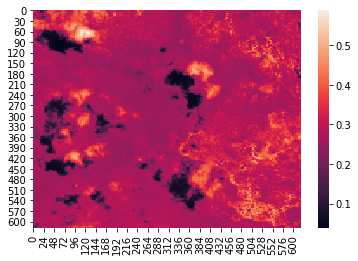

In [179]:
sns.heatmap(arr[3, ..., 10])

In [8]:
arr = np.clip(arr, min_v, max_v)
arr = minmax(arr)

In [22]:
preds = predict_sess.run(predict_logits,
                              feed_dict={predict_input:arr[2, :512, :512][np.newaxis]})

<AxesSubplot:>

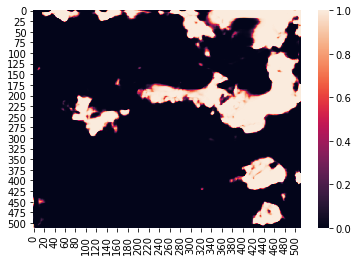

In [23]:
import seaborn as sns
sns.heatmap(preds[0, ..., 4])

<AxesSubplot:>

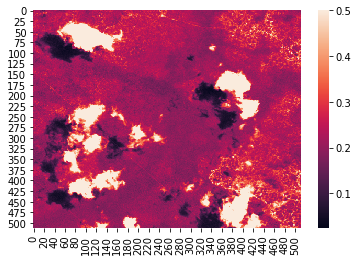

In [19]:
sns.heatmap(arr[-3, :512, :512, 1], vmax = 0.5)

<AxesSubplot:>

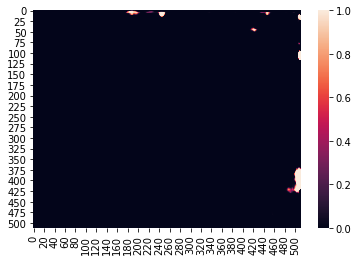

In [171]:
import seaborn as sns
sns.heatmap(preds[0, ..., 4])

In [50]:
preds.squeeze().shape

(512, 512, 6)

In [48]:
l = np.argmax(preds.squeeze, axis = -1)
l

0